In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, MaxPooling1D, Flatten, Conv1D, GRU
from  tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import random as python_random

np.random.seed(42)
python_random.seed(42)
tf.random.set_seed(42)

import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'

2024-03-17 20:51:06.067660: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('full_hand_data_big_set.csv')

df.dropna(inplace=True)

correlation_columns = ['left_landmark_1_z', 'left_landmark_2_z', 'left_landmark_3_z', 'left_landmark_4_z', 'left_landmark_12_x', 'left_landmark_12_y', 'left_landmark_11_y', 'left_landmark_11_x', 'left_landmark_8_x', 'left_landmark_10_y', 'left_landmark_19_y', 'left_landmark_20_y', 'left_landmark_7_y', 'left_landmark_8_y', 'left_landmark_14_y', 'left_landmark_18_y', 'left_landmark_15_y', 'left_landmark_10_x', 'left_landmark_6_y', 'left_landmark_7_x', 'left_landmark_17_z', 'video_id', 'label', 'frame_id']

record_columns = df[correlation_columns]

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df['label'])
categorical_labels = to_categorical(encoded_labels)

/opt/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [3]:
features = record_columns.drop(['label', 'video_id', 'frame_id'], axis=1).values

grouped = record_columns.groupby('video_id').apply(lambda x: x.sort_values('frame_id')).reset_index(drop=True)

max_sequence_length = grouped['frame_id'].max() + 1  

X = np.zeros((len(grouped['video_id'].unique()), max_sequence_length, features.shape[1]))

stratify_labels = np.array([group['label'].iloc[0] for _, group in grouped.groupby('video_id')])

label_encoder = LabelEncoder()
stratify_labels_encoded = label_encoder.fit_transform(stratify_labels)

y = np.zeros((len(grouped['video_id'].unique()), categorical_labels.shape[1]))

for i, (video_id, group) in enumerate(grouped.groupby('video_id')):
    X[i, :len(group)] = group.drop(['label', 'video_id', 'frame_id'], axis=1)
    y[i] = categorical_labels[group.index[0]] 
    

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=stratify_labels_encoded)

In [4]:
model = Sequential()

model.add(Conv1D(200, kernel_size=2, activation = 'relu', input_shape=(max_sequence_length, features.shape[1])))
model.add(Conv1D(200, kernel_size=2, activation = 'relu'))
model.add(MaxPooling1D(3))

model.add(LSTM(160, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(160))
model.add(Dense(y_train.shape[1], activation='softmax'))

2024-03-17 20:52:19.539079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-17 20:52:19.540198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-17 20:52:19.540845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [5]:
optimizer = optimizers.Adam(learning_rate=0.0002)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [6]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=400)

Epoch 1/400


2024-03-17 20:52:27.013915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1015,33]
	 [[{{node Placeholder/_11}}]]
2024-03-17 20:52:27.014165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1015,33]
	 [[{{node Placeholder/_11}}]]
2024-03-17 20:52:27.275812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/spl

32/32 [==============================] - ETA: 0s - loss: 3.4964 - categorical_accuracy: 0.0414

2024-03-17 20:52:31.929368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [254,33]
	 [[{{node Placeholder/_11}}]]
2024-03-17 20:52:31.929571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [254,33]
	 [[{{node Placeholder/_11}}]]
2024-03-17 20:52:32.080832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split

32/32 [==============================] - 6s 97ms/step - loss: 3.4964 - categorical_accuracy: 0.0414 - val_loss: 3.4932 - val_categorical_accuracy: 0.0551
Epoch 2/400
32/32 [==============================] - 2s 77ms/step - loss: 3.4768 - categorical_accuracy: 0.0325 - val_loss: 3.4620 - val_categorical_accuracy: 0.0276
Epoch 3/400
32/32 [==============================] - 2s 77ms/step - loss: 3.3700 - categorical_accuracy: 0.0709 - val_loss: 3.3391 - val_categorical_accuracy: 0.0669
Epoch 4/400
32/32 [==============================] - 2s 77ms/step - loss: 3.2153 - categorical_accuracy: 0.0897 - val_loss: 3.2711 - val_categorical_accuracy: 0.0748
Epoch 5/400
32/32 [==============================] - 2s 77ms/step - loss: 3.1211 - categorical_accuracy: 0.1015 - val_loss: 3.2497 - val_categorical_accuracy: 0.0906
Epoch 6/400
32/32 [==============================] - 2s 77ms/step - loss: 3.0856 - categorical_accuracy: 0.1015 - val_loss: 3.2171 - val_categorical_accuracy: 0.0906
Epoch 7/400
32/3

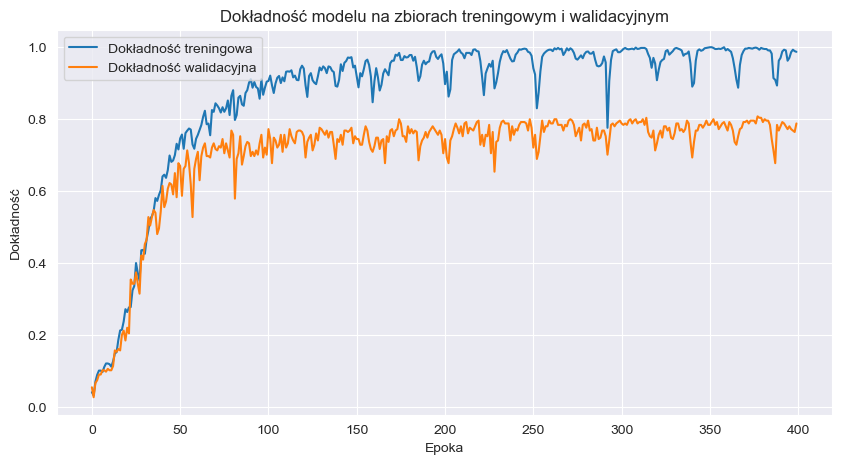

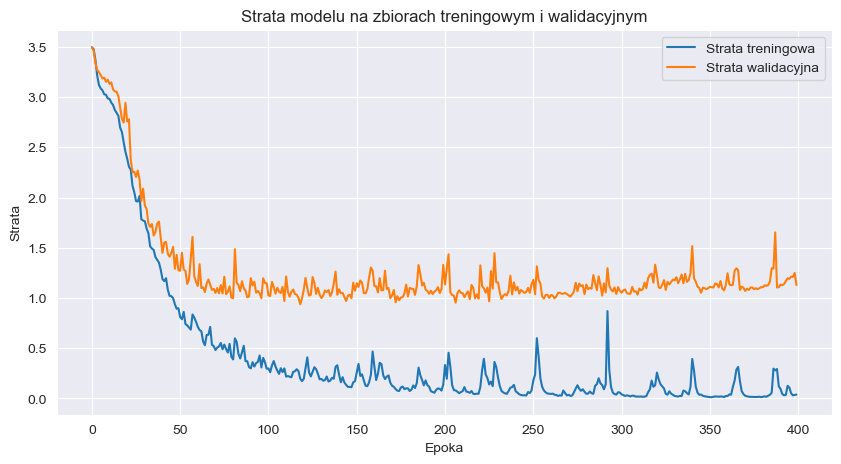

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['categorical_accuracy'], label='Dokładność treningowa')
plt.plot(history.history['val_categorical_accuracy'], label='Dokładność walidacyjna')
plt.title('Dokładność modelu na zbiorach treningowym i walidacyjnym')
plt.ylabel('Dokładność')
plt.xlabel('Epoka')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Strata treningowa')
plt.plot(history.history['val_loss'], label='Strata walidacyjna')
plt.title('Strata modelu na zbiorach treningowym i walidacyjnym')
plt.ylabel('Strata')
plt.xlabel('Epoka')
plt.legend(loc='upper right')
plt.show()


2024-03-17 21:20:26.458251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [254,144,21]
	 [[{{node Placeholder/_10}}]]
2024-03-17 21:20:26.458456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [254,144,21]
	 [[{{node Placeholder/_10}}]]
2024-03-17 21:20:26.627558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split

8/8 [==============================] - 1s 29ms/step


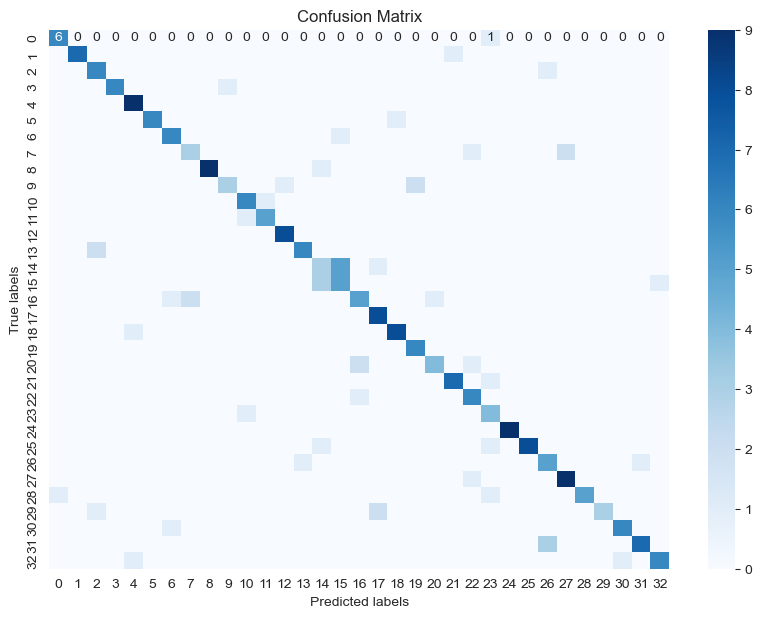

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)

y_test_class = np.argmax(y_test, axis=1)
y_pred_class = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test_class, y_pred_class)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [9]:
from sklearn.metrics import classification_report

class_labels = df['label'].unique()

print(classification_report(y_test_class, y_pred_class, target_names=class_labels))

              precision    recall  f1-score   support

          CH       0.86      0.86      0.86         7
          CZ       1.00      0.88      0.93         8
           Ł       0.67      0.86      0.75         7
           R       1.00      0.86      0.92         7
           U       0.82      1.00      0.90         9
           I       1.00      0.86      0.92         7
           N       0.75      0.86      0.80         7
           G       0.60      0.50      0.55         6
           Z       1.00      0.90      0.95        10
           T       0.75      0.50      0.60         6
          RZ       0.75      0.86      0.80         7
           S       0.83      0.83      0.83         6
           A       0.89      1.00      0.94         8
           Ó       0.86      0.75      0.80         8
           F       0.38      0.33      0.35         9
           O       0.45      0.56      0.50         9
           H       0.62      0.56      0.59         9
          SZ       0.73    

In [2]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

df = pd.read_csv('partial_hand_data_big_set.csv')

df.dropna(inplace=True)

target_column = 'label'

le = LabelEncoder()
df[target_column] = le.fit_transform(df[target_column])

correlation_with_target = df.corr()[target_column].sort_values(ascending=False)

print(correlation_with_target)

/opt/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


label                 1.000000
left_landmark_1_z     0.257426
left_landmark_2_z     0.228869
left_landmark_3_z     0.204285
left_landmark_4_z     0.178601
                        ...   
left_landmark_1_x    -0.030076
left_landmark_0_x    -0.031901
left_landmark_18_z   -0.056628
left_landmark_13_z   -0.080819
left_landmark_17_z   -0.132085
Name: label, Length: 66, dtype: float64


In [5]:
significant_correlations = correlation_with_target[abs(correlation_with_target) > 0.1]
print(significant_correlations.index.tolist())

['label', 'left_landmark_1_z', 'left_landmark_2_z', 'left_landmark_3_z', 'left_landmark_4_z', 'left_landmark_12_x', 'left_landmark_12_y', 'left_landmark_11_y', 'left_landmark_11_x', 'left_landmark_8_x', 'left_landmark_10_y', 'left_landmark_19_y', 'left_landmark_20_y', 'left_landmark_7_y', 'left_landmark_8_y', 'left_landmark_14_y', 'left_landmark_18_y', 'left_landmark_15_y', 'left_landmark_10_x', 'left_landmark_6_y', 'left_landmark_7_x', 'left_landmark_17_z']


In [10]:
model.save("model_result.h5")